# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import json
import numpy as np
import pandas as pd
import pprint
import time
import yaml

from benchmarks.generator import get_revenue_behaviour
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    services = generator.generate(file_name=generator_save_path,
                                   path_config=generator_config_path,
                                   n_services=n_services,
                                   seed=seed)
    print(f'Number of service requests generated: {len(services)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
AVLO                    4
IRYO                   10
AVE                     6
OUIGO                   5
Total                  25


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour(supply)

Services:  25


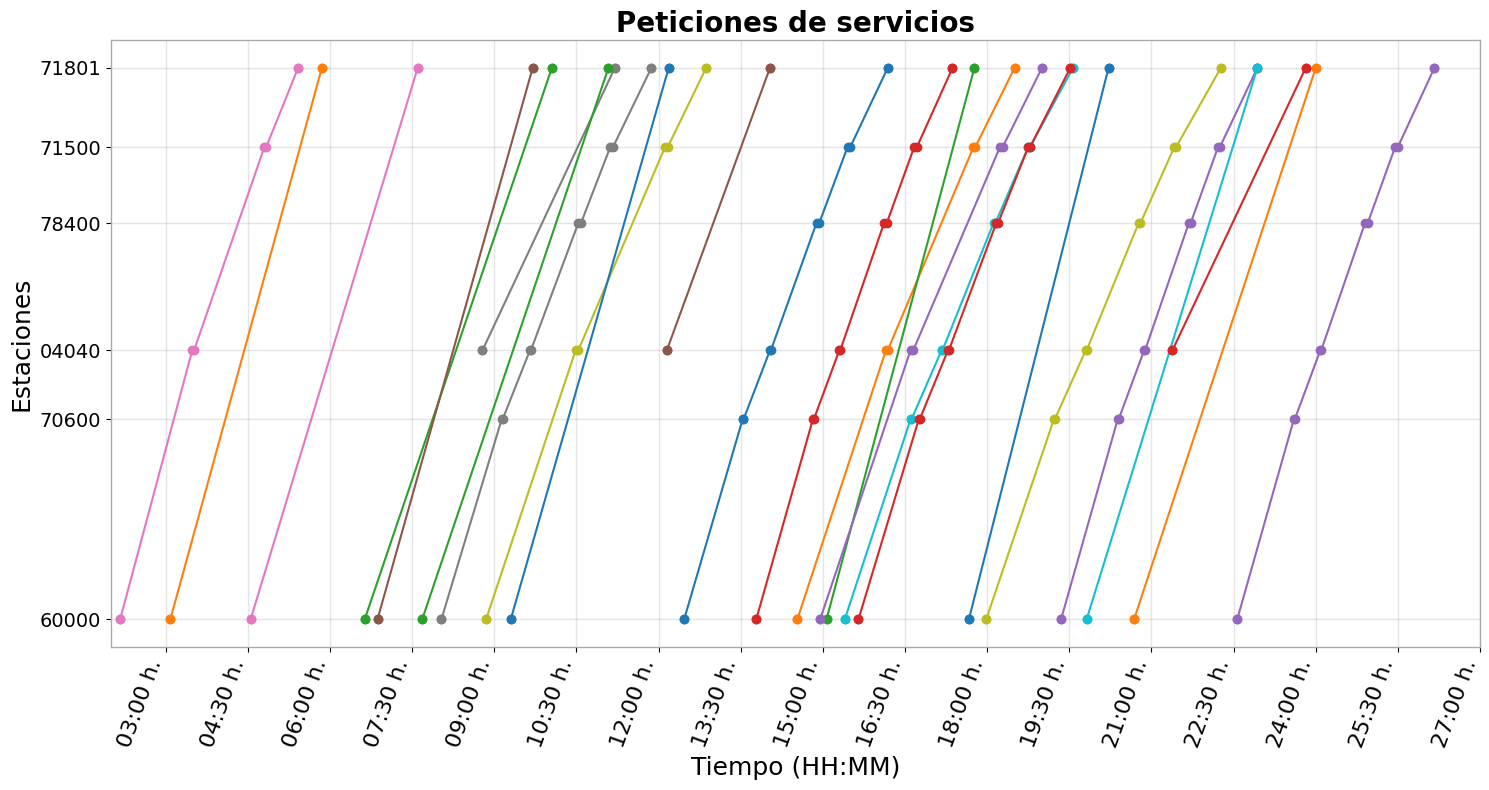

In [6]:
lines = supply.lines
line = infer_line_stations(lines)

plotter = TrainSchedulePlotter(requested_schedule, line)
plotter.plot(main_title="Peticiones de servicios")

In [7]:
#pr = profile.Profile()
#pr.enable()
import random

def run_gsa(chaotic_constant: bool=False,
            runs: int=10,
            population_size: int=20,
            iters: int=50,
            global_seed: int=21
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    random.seed(global_seed)
    
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in range(1, runs + 1):
        print(f"Run {r}")
        sm = RevenueMaximization(requested_schedule=requested_schedule,
                                 revenue_behaviour=revenue_behaviour,
                                 line=line,
                                 safe_headway=10)
    
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
        
        gsa_algo.set_seed(seed=random.randint(0, 1000))
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iters,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=True,
                                             initial_population=sm.get_initial_population(population),
                                             verbose=verbosity,
                                             save_population=True)
    
        training_history.insert(0, "Run", r)
        training_history['Discrete'] = [sm.get_heuristic_schedule(Solution(real=r, discrete=np.array([]))) for r in training_history['Real']]
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        gsa_algo.population_history.insert(0, "Run", r)
        global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
        
    return global_train_hist, global_population_hist, runs_best_solution_history
        
#pr.disable()
#pr.dump_stats('profile.pstat')

## 1. Chaotic vs Normal GSA

In [8]:
runs = 5
population = 20
iters = 150
verbosity = False
rbs_hist = {}

df_gcc = pd.DataFrame()
df_gpp = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    df_train, df_pop, rbs_hist[chaotic_constant] = run_gsa(chaotic_constant=chaotic_constant,
                                                           runs=runs,
                                                           population_size=population,
                                                           iters=iters)
    
    df_train["chaotic_constant"] = chaotic_constant
    df_gcc = pd.concat([df_gcc, df_train], axis=0)
    
    df_pop["chaotic_constant"] = chaotic_constant
    df_gpp = pd.concat([df_gpp, df_pop], axis=0)

Running GSA with chaotic constant:  True
Run 1
Run 2
Run 3
Run 4
Run 5
Running GSA with chaotic constant:  False
Run 1
Run 2
Run 3
Run 4
Run 5


## 2. Results analysis

In [9]:
# Define new revenue maximization object for results analysis
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [10]:
# Create dataframe with fitness values for each individual of the population
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,real_11,real_12,real_13,real_14,real_15,real_16,real_17,real_18,real_19,chaotic_constant
0,1,0,58071.253752,58330.389975,58016.456398,57919.77615,58090.413059,58583.07057,60844.204687,57590.809578,...,57733.231384,57161.007047,58350.998476,57511.575469,58865.681926,57543.807489,58054.715984,57881.519419,58099.237622,True
1,1,1,58791.625983,56325.438554,59346.727944,55749.517068,55320.938079,51144.315691,57448.904324,56371.194861,...,54615.2566,55622.338371,50935.577156,56189.71881,57541.928341,56065.041227,54404.674843,51319.390182,52313.755566,True
2,1,2,59759.437897,58252.584709,60667.494964,57474.674581,57487.234628,53533.916604,57646.938419,56998.803911,...,53677.471126,57775.387442,55735.880439,57402.809809,57944.258059,58014.638048,59539.996196,56584.376181,53449.337365,True
3,1,3,55769.569409,57505.518772,53300.097525,56749.30239,57766.529128,57978.201762,58867.574076,52952.850362,...,59686.684556,56501.307743,57033.127799,56874.822036,54509.175647,55939.732558,57245.286282,56244.073085,56850.42004,True
4,1,4,58230.827888,58347.202925,57712.01342,57422.179194,59365.755833,55719.721024,58876.067864,57778.676959,...,59777.914651,58174.686561,55357.109126,59951.300182,56972.212786,56977.314732,57440.537203,59082.900014,58268.228921,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,5,145,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59536.151796,59501.367984,59501.367984,...,59476.866702,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,False
146,5,146,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59536.151796,59501.367984,59501.367984,...,59476.866702,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,False
147,5,147,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59536.151796,59501.367984,59501.367984,...,59476.866702,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,False
148,5,148,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59536.151796,59501.367984,59501.367984,...,59476.866702,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,59501.367984,False


In [11]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Chaotic,Individual
0,1,0,58071.253752,True,ID_real_0
1,1,0,58330.389975,True,ID_real_1
2,1,0,58016.456398,True,ID_real_2
3,1,0,57919.776150,True,ID_real_3
4,1,0,58090.413059,True,ID_real_4
...,...,...,...,...,...
29995,5,149,59501.367984,False,ID_real_15
29996,5,149,59501.367984,False,ID_real_16
29997,5,149,59501.367984,False,ID_real_17
29998,5,149,59501.367984,False,ID_real_18


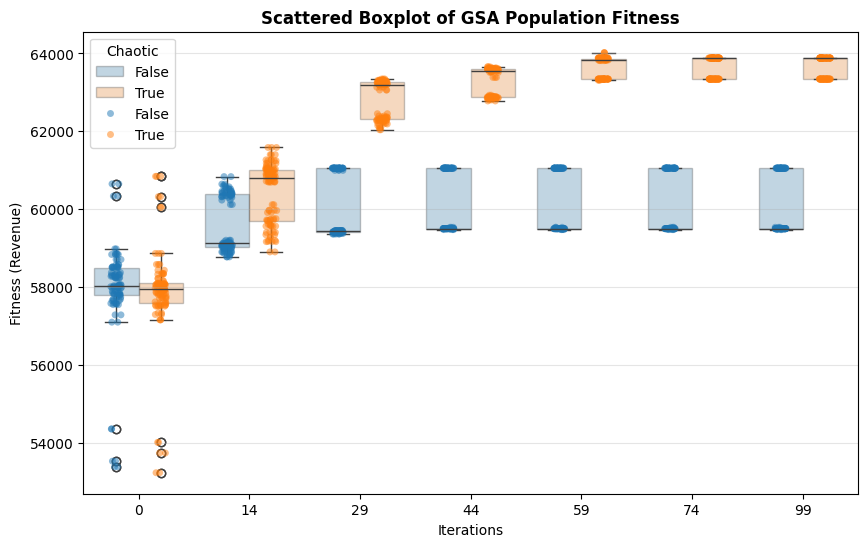

In [12]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 14, 29, 44, 59, 74, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Scattered Boxplot of GSA Population Fitness",
             x_label="Iterations",
             y_label="Fitness (Revenue)",
             save_path=Path('../figures/scattered_boxplot.pdf'))

In [13]:
df_gcc

,Run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real,chaotic_constant
0,1,0,56312.936229,0,0.065958,"[True, True, False, True, True, True, True, Fa...","[1060, 880, 979, 1075, 909, 817, 883, 919, 970...",True
1,1,1,60844.204687,0,0.271419,"[True, True, False, True, True, True, True, Fa...","[1058.0, 872.0, 974.0, 1072.0, 903.0, 828.0, 8...",True
2,1,2,60844.204687,0,0.469756,"[True, True, False, True, True, True, True, Fa...","[1058.0, 872.0, 974.0, 1072.0, 903.0, 828.0, 8...",True
3,1,3,60844.204687,0,0.663527,"[True, True, False, True, True, True, True, Fa...","[1058.0, 872.0, 974.0, 1072.0, 903.0, 828.0, 8...",True
4,1,4,60844.204687,0,0.868161,"[True, True, False, True, True, True, True, Fa...","[1058.0, 872.0, 974.0, 1072.0, 903.0, 828.0, 8...",True
...,...,...,...,...,...,...,...,...
145,5,145,60844.149172,0,25.734176,"[True, True, False, True, True, True, True, Fa...","[1059, 871, 970, 1070, 910, 829, 897, 928, 979...",False
146,5,146,60844.149172,0,25.898387,"[True, True, False, True, True, True, True, Fa...","[1059, 871, 970, 1070, 910, 829, 897, 928, 979...",False
147,5,147,60844.149172,0,26.063229,"[True, True, False, True, True, True, True, Fa...","[1059, 871, 970, 1070, 910, 829, 897, 928, 979...",False
148,5,148,60844.149172,0,26.226856,"[True, True, False, True, True, True, True, Fa...","[1059, 871, 970, 1070, 910, 829, 897, 928, 979...",False


In [19]:
# Table with results by run

def get_gsa_table_results(chaotic: bool = True) -> pd.DataFrame:
    service_tsps = {service.id: service.tsp.name for service in supply.services}
    columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
    columns += set(service_tsps.values())
    
    summary_df = pd.DataFrame(columns=columns)
    
    df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == chaotic]
    run_grouped_df = df_train_chaotic.groupby('Run')
    
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
        execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
        row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data
    
    return summary_df.sort_values('Revenue', ascending=False)

summary_df = get_gsa_table_results(chaotic=True)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),AVE,IRYO,OUIGO,AVLO
0,1,64017.494961,26.537947,16,6.0,71.0,75.0 %,80.0 %,50.0 %,40.0 %
2,3,64017.494961,26.145363,16,6.0,71.0,75.0 %,80.0 %,50.0 %,40.0 %
4,5,64017.494961,26.186523,16,6.0,71.0,75.0 %,80.0 %,50.0 %,40.0 %
1,2,63341.392951,26.224448,16,7.0,98.0,75.0 %,80.0 %,50.0 %,40.0 %
3,4,63341.392951,26.091082,16,7.0,98.0,75.0 %,80.0 %,50.0 %,40.0 %


In [20]:
summary_df_nc = get_gsa_table_results(chaotic=False)
display(summary_df_nc)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),AVE,IRYO,OUIGO,AVLO
1,2,63021.896233,25.609316,16,26.0,147.0,75.0 %,70.0 %,66.67 %,40.0 %
3,4,63021.896233,25.461566,16,26.0,147.0,75.0 %,70.0 %,66.67 %,40.0 %
0,1,60844.149172,25.859247,15,19.0,121.0,50.0 %,80.0 %,50.0 %,40.0 %
2,3,60844.149172,25.442819,15,19.0,121.0,50.0 %,80.0 %,50.0 %,40.0 %
4,5,60844.149172,26.389761,15,19.0,121.0,50.0 %,80.0 %,50.0 %,40.0 %


In [25]:
# Global status

def get_gsa_global_status(df: pd.DataFrame):
    run_grouped_df = df.groupby('Run')
    print("Global GSA status:")
    
    # Execution time (mean and std.)
    run_times = run_grouped_df['ExecutionTime'].last()
    print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
    print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
    
    # Revenue (mean and std.)
    run_revenues = run_grouped_df['Fitness'].last()
    print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
    
    # Scheduled trains (mean and std.)
    run_trains = run_grouped_df['Discrete'].last().apply(sum)
    print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
    
    runs_best_solution_history = dict(sorted(rbs_hist[True].items(),
                                             key=lambda x: x[1][1]))
    
    q2_solution_index = np.floor(runs // 2).astype(int)
    gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]
    
    print(f"\tMedian solution: Run {gsa_solution[0]}")
    max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
    print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
    
    return gsa_solution

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
gsa_solution = get_gsa_global_status(df_train_chaotic)

Global GSA status:
	Total execution time: 131.1854 s.
	Execution Time (by run) - Mean: 26.2371 s. - Std: 0.1753 s.
	Revenue - Mean: 63747.0542 - Std: 370.3163
	Scheduled Trains - Mean: 16.0 - Std: 0.0
	Median solution: Run 1
	Max Revenue: 104021.88392196884 - WARNING!: Scheduling all services could not be feasible


In [27]:
df_train_nc = df_gcc[df_gcc['chaotic_constant'] == False]
_ = get_gsa_global_status(df_train_nc)

Global GSA status:
	Total execution time: 128.7627 s.
	Execution Time (by run) - Mean: 25.7525 s. - Std: 0.3932 s.
	Revenue - Mean: 61715.248 - Std: 1192.8012
	Scheduled Trains - Mean: 15.0 - Std: 1.0
	Median solution: Run 1
	Max Revenue: 104021.88392196884 - WARNING!: Scheduling all services could not be feasible


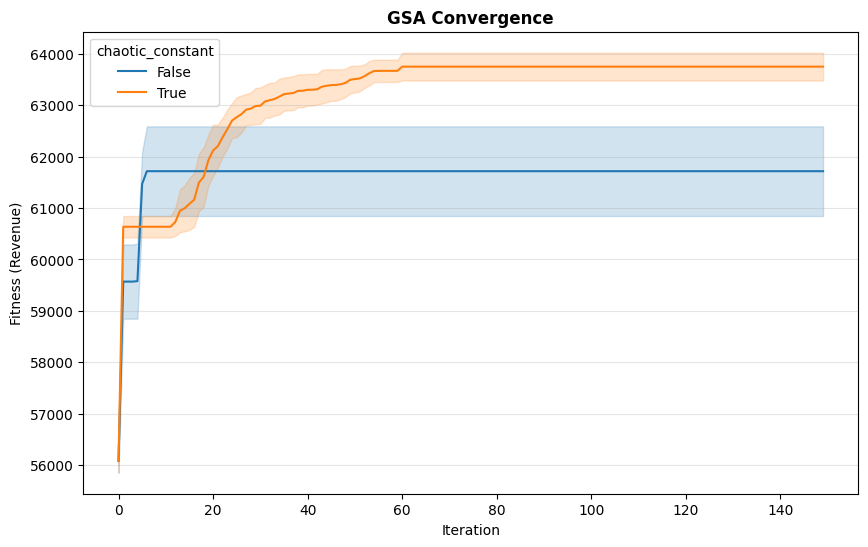

In [28]:
# GSA Convergence plot
sns_line_plot(df=df_gcc,
              x_data="Iteration",
              y_data="Fitness",
              hue="chaotic_constant",
              title="GSA Convergence",
              x_label="Iteration",
              y_label="Fitness (Revenue)",
              save_path=Path('../figures/gsa_convergence.pdf'))

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


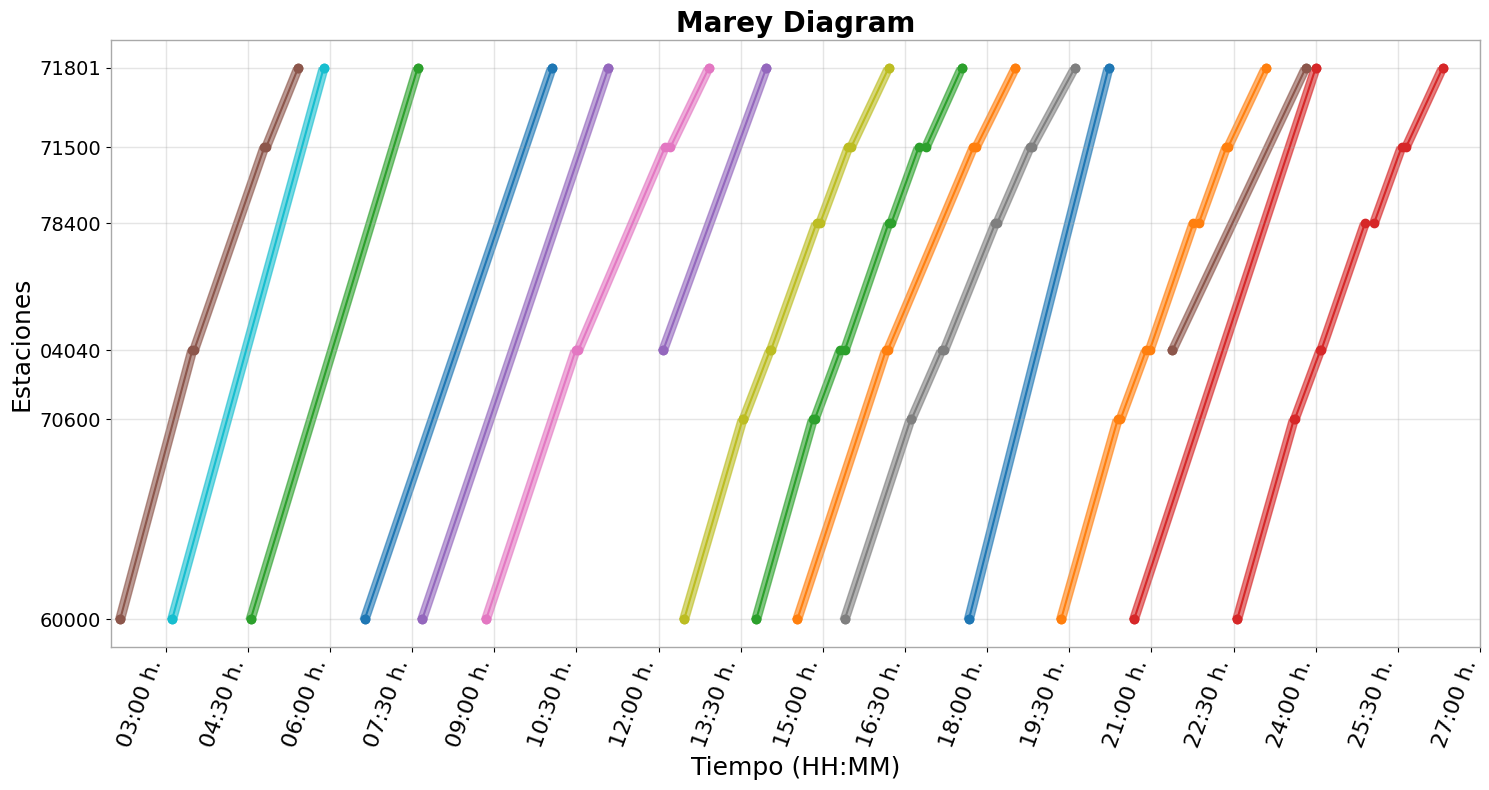

In [29]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

plotter = TrainSchedulePlotter(filtered_services, line)
plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)
supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [17]:
#!snakeviz profile.pstat

In [18]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_file,
                path_config_demand=demand_config_path,
                seed=21)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'),
                           save_trace=True,
                           departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_file)

kernel_plotter.plotter_data_analysis()

Data from demand plot: 
	Status: User found  any service that met his needs but couldn't purchase. - Passengers: 6298
	Status: User bought a service which was not the one with the best utility. - Passengers: 1763
	Status: User bought the ticket with best utility. - Passengers: 730
	Status: User didn't find any ticket that met his needs. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  2493
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 356 - Percentage: 14.28 %
		Seat: Turista - Passengers: 1867 - Percentage: 74.89 %
		Seat: TuristaPlus - Passengers: 270 - Percentage: 10.83 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  2493
	Tickets sold by purchase date and seat type: 
		Date: 2023-06-11
			Seat: Premium - Number of tickets sold: 62
			Seat: Turista - Number of tickets sold: 179
			Seat: TuristaPlus - Number of tickets sold: 223
		Date: 2023-06-12
			Seat: Premium - Number of tickets sold: 24
			Seat: Turista - Number of t

{'Tourist': {'TuristaPlus': 181, 'Turista': 986}, 'EventTourist': {'Premium': 60, 'Turista': 292}, 'Adventurer': {'Premium': 100, 'TuristaPlus': 89, 'Turista': 12}, 'Business': {'Premium': 196, 'Turista': 310}, 'Student': {'Turista': 267}}


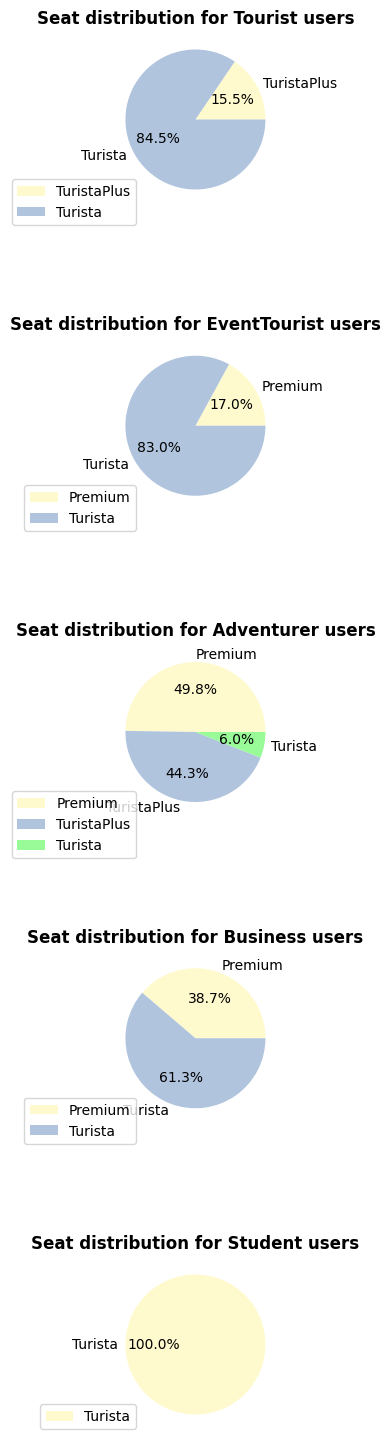

In [19]:
kernel_plotter.plot_users_seat_pie_chart(save_path='../figures/users_seat_pie_chart.pdf')

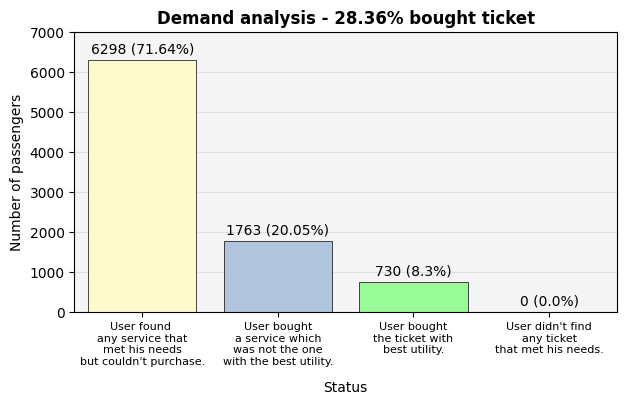

In [20]:
kernel_plotter.plot_demand_status(y_limit=7000)

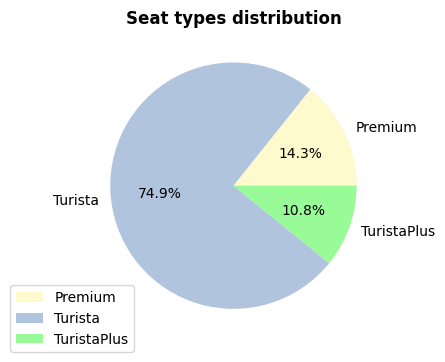

In [21]:
kernel_plotter.plot_seat_distribution_pie_chart()

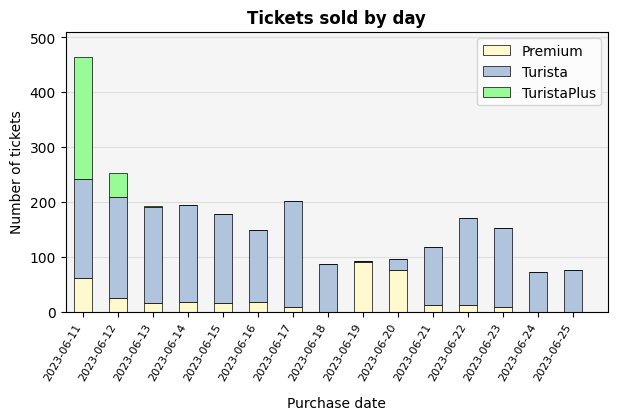

In [22]:
kernel_plotter.plot_tickets_by_date()

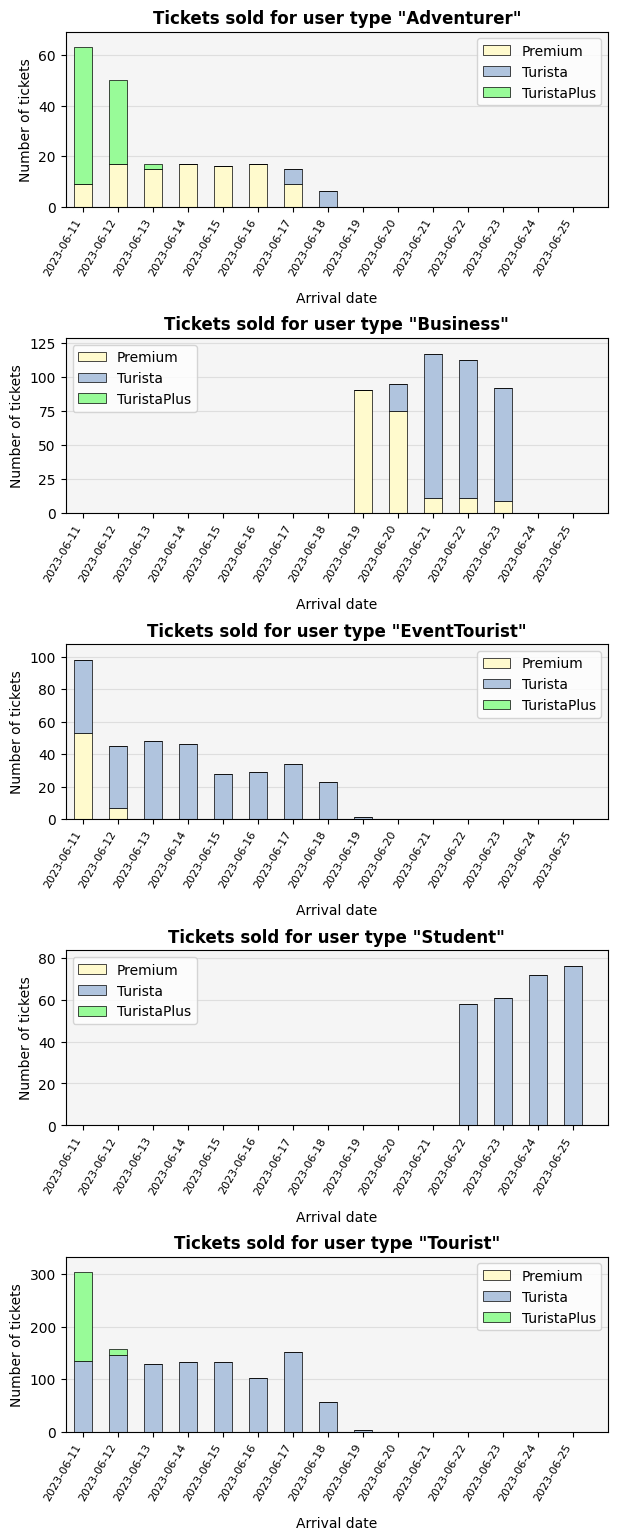

In [23]:
kernel_plotter.plot_tickets_by_user()

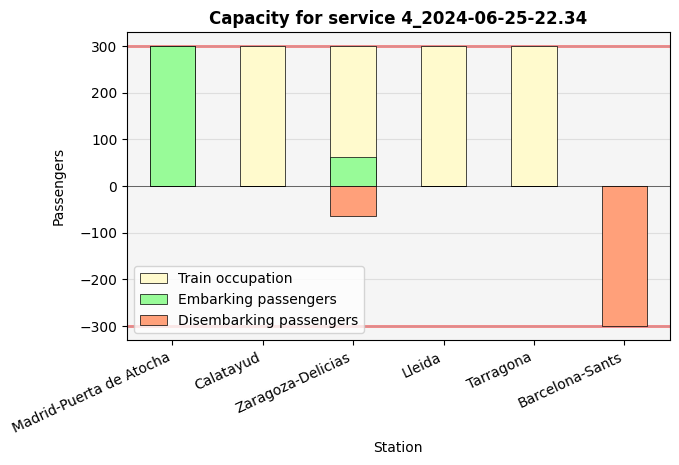

In [24]:
kernel_plotter.plot_service_capacity(service_id='4_2024-06-25-22.34')

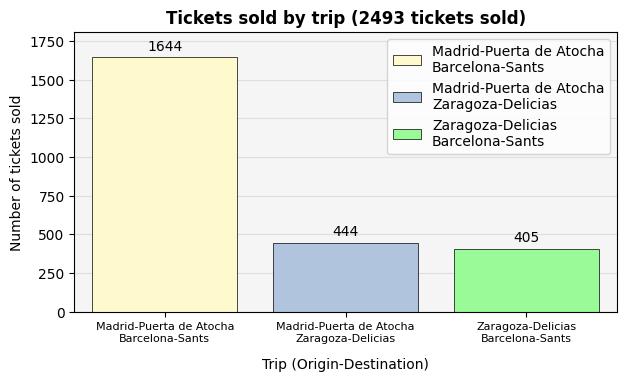

In [25]:
kernel_plotter.plot_tickets_by_pair()

## Load inference trace

In [26]:
trace_path = Path(f'{robin_save_path}/inference_trace.json')

# Load trace json
with open(trace_path, 'r') as f:
    trace = json.load(f)

In [27]:
# Tickets bought by user pattern

n_pass = {}
for t in trace:
   if trace[t]['user_pattern'] not in n_pass:
       n_pass[trace[t]['user_pattern']] = 1
   else:
       n_pass[trace[t]['user_pattern']] += 1

n_pass

{'Tourist': 1167,
 'EventTourist': 352,
 'Adventurer': 201,
 'Business': 506,
 'Student': 267}

## Load user patterns and variables from demand config file

In [28]:
# Load demand config yaml
with open(demand_config_path, 'r') as f:
    demand_config = yaml.safe_load(f)

In [29]:
user_patterns = []
variables = {}
rules = {}

for user_pattern in demand_config['userPattern']:
    user_patterns.append(user_pattern['name'])
    for variable in user_pattern['variables']:
        if variable['name'] not in variables:
            if variable['type'] == 'fuzzy':
                variables[variable['name']] = variable['sets']
            elif variable['type'] == 'categorical':
                variables[variable['name']] = variable['labels']
        else:
            # Assert set matches
            if variable['type'] == 'fuzzy':
                assert variables[variable['name']] == variable['sets']
            elif variable['type'] == 'categorical':
                assert variables[variable['name']] == variable['labels']
                
    rules[user_pattern['name']] = [rule for rule in user_pattern['rules']]
                
print(user_patterns)
pprint.pp(variables)
pprint.pp(rules)

['Business', 'Student', 'Tourist', 'EventTourist', 'Adventurer']
{'origin': ['very_near', 'mid_range', 'far', 'far_away'],
 'destination': ['very_near', 'mid_range', 'far', 'far_away'],
 'departure_time': ['in_time', 'close', 'remote', 'very_remote'],
 'arrival_time': ['in_time', 'close', 'remote', 'very_remote'],
 'price': ['very_cheap', 'cheap', 'medium', 'expensive'],
 'seat': ['Turista', 'TuristaPlus', 'Premium'],
 'tsp': ['AVE', 'AVLO', 'OUIGO', 'IRYO']}
{'Business': ['R0', 'R1', 'R2'],
 'Student': ['R0', 'R1', 'R2', 'R3'],
 'Tourist': ['R0', 'R1', 'R2', 'R3'],
 'EventTourist': ['R0', 'R1', 'R2'],
 'Adventurer': ['R0', 'R1', 'R2']}


In [36]:
# Create dataframes for each behaviour variable

behaviour_dfs = {}
for variable in variables:
    behaviour_dfs[variable] = pd.DataFrame(columns=user_patterns, index=variables[variable])
    
    for variable_set in variables[variable]:
        behaviour_dfs[variable].loc[variable_set] = [np.zeros(3) for _ in range(len(user_patterns))]
        
    print(behaviour_dfs[variable])

                  Business          Student          Tourist     EventTourist  \
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   

                Adventurer  
very_near  [0.0, 0.0, 0.0]  
mid_range  [0.0, 0.0, 0.0]  
far        [0.0, 0.0, 0.0]  
far_away   [0.0, 0.0, 0.0]  
                  Business          Student          Tourist     EventTourist  \
very_near  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
mid_range  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far        [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   
far_away   [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]   

                Adventurer  
very_near  [0.

In [37]:
def update_behaviour_dfs(behaviour_dfs: Mapping[str, pd.DataFrame],
                         user_pattern: str,
                         rules: List):
    passenger_set = set()
    def recurse_elements(element):
        if isinstance(element, dict):
            if 'variable' in element:
                if element['variable'] in behaviour_dfs:
                    set_name_and_values = element['setname_and_values']
                    set_name = set_name_and_values[0] if type(set_name_and_values) is list else set_name_and_values
                    if set_name in behaviour_dfs[element['variable']].index:
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][0] += element['result']
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][1] += 1
                        if (element['variable'], set_name) not in passenger_set:
                            behaviour_dfs[element['variable']].loc[set_name, user_pattern][2] += 1
                            passenger_set.add((element['variable'], set_name))
            for value in element.values():
                recurse_elements(value)
        elif isinstance(element, list):
            for item in element:
                recurse_elements(item)

    for rule in rules:
        recurse_elements(rule)

    return behaviour_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_behaviour_dfs(behaviour_dfs=behaviour_dfs,
                                         user_pattern=user_pattern,
                                         rules=trace[passenger]['trace_of_each_rule'])

In [38]:
# Multicolumn pandas dataframes

for df in behaviour_dfs: 
    values = behaviour_dfs[df].values
    np_vals = np.array([val for row in values for data in row for val in data], dtype=np.float32)
    np_vals = np_vals.reshape(len(behaviour_dfs[df].index), 3 * len(user_patterns))
    
    midx = pd.MultiIndex.from_product([user_patterns, ['Sum', 'Count', 'Passengers']])
    multicol_df = pd.DataFrame(np_vals, index=behaviour_dfs[df].index, columns=midx)
    display(multicol_df)

Business                   Student                   Tourist  \
               Sum  Count Passengers     Sum  Count Passengers     Sum   
very_near    506.0  506.0      506.0   534.0  534.0      267.0  1167.0   
mid_range      0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far            0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far_away       0.0    0.0        0.0     0.0    0.0        0.0     0.0   

                             EventTourist                   Adventurer        \
            Count Passengers          Sum  Count Passengers        Sum Count   
very_near  1167.0     1167.0        352.0  352.0      352.0        0.0   0.0   
mid_range  1167.0     1167.0          0.0    0.0        0.0        0.0   0.0   
far           0.0        0.0          0.0    0.0        0.0        0.0   0.0   
far_away      0.0        0.0          0.0    0.0        0.0        0.0   0.0   

                      
          Passengers  
very_near        0.0  
mid_range        0.0  
far              0.0  
far_away         0.0

Business                   Student                   Tourist  \
               Sum  Count Passengers     Sum  Count Passengers     Sum   
very_near    506.0  506.0      506.0   534.0  534.0      267.0  1167.0   
mid_range      0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far            0.0    0.0        0.0     0.0    0.0        0.0     0.0   
far_away       0.0    0.0        0.0     0.0    0.0        0.0     0.0   

                             EventTourist                   Adventurer        \
            Count Passengers          Sum  Count Passengers        Sum Count   
very_near  1167.0     1167.0        352.0  352.0      352.0        0.0   0.0   
mid_range     0.0        0.0          0.0    0.0        0.0        0.0   0.0   
far           0.0        0.0          0.0    0.0        0.0        0.0   0.0   
far_away      0.0        0.0          0.0    0.0        0.0        0.0   0.0   

                      
          Passengers  
very_near        0.0  
mid_range        0.0  
far              0.0  
far_away         0.0

Business                   Student                   Tourist  \
                 Sum  Count Passengers     Sum  Count Passengers     Sum   
in_time        506.0  506.0      506.0   267.0  267.0      267.0     0.0   
close            0.0    0.0        0.0     0.0    0.0        0.0     0.0   
remote           0.0    0.0        0.0     0.0    0.0        0.0     0.0   
very_remote      0.0    0.0        0.0     0.0    0.0        0.0     0.0   

                             EventTourist                   Adventurer        \
            Count Passengers          Sum  Count Passengers        Sum Count   
in_time       0.0        0.0   300.640015  352.0      352.0        0.0   0.0   
close         0.0        0.0     0.000000    0.0        0.0        0.0   0.0   
remote        0.0        0.0     0.000000    0.0        0.0        0.0   0.0   
very_remote   0.0        0.0     0.000000    0.0        0.0        0.0   0.0   

                        
            Passengers  
in_time            0.0  
close              0.0  
remote             0.0  
very_remote        0.0

Business                   Student                   Tourist  \
                 Sum  Count Passengers     Sum  Count Passengers     Sum   
in_time        506.0  506.0      506.0   267.0  267.0      267.0     0.0   
close            0.0    0.0        0.0     0.0    0.0        0.0     0.0   
remote           0.0    0.0        0.0     0.0    0.0        0.0     0.0   
very_remote      0.0    0.0        0.0     0.0    0.0        0.0     0.0   

                             EventTourist                   Adventurer        \
            Count Passengers          Sum  Count Passengers        Sum Count   
in_time       0.0        0.0   263.601654  352.0      352.0        0.0   0.0   
close         0.0        0.0     0.000000    0.0        0.0        0.0   0.0   
remote        0.0        0.0     0.000000    0.0        0.0        0.0   0.0   
very_remote   0.0        0.0     0.000000    0.0        0.0        0.0   0.0   

                        
            Passengers  
in_time            0.0  
close              0.0  
remote             0.0  
very_remote        0.0

Business                  Student                       Tourist  \
                Sum Count Passengers     Sum  Count Passengers         Sum   
very_cheap      0.0   0.0        0.0     0.0  534.0      267.0   41.103001   
cheap           0.0   0.0        0.0   534.0  534.0      267.0  516.968018   
medium          0.0   0.0        0.0     0.0    0.0        0.0    0.000000   
expensive       0.0   0.0        0.0     0.0    0.0        0.0    0.000000   

                             EventTourist                    Adventurer  \
            Count Passengers          Sum  Count Passengers         Sum   
very_cheap  565.0      565.0     0.000000  352.0      352.0    4.141000   
cheap       565.0      565.0    38.028000  352.0      352.0  196.507996   
medium        0.0        0.0   313.656006  352.0      352.0    0.000000   
expensive     0.0        0.0     0.000000    0.0        0.0    0.000000   

                              
            Count Passengers  
very_cheap  201.0      201.0  
cheap       201.0      201.0  
medium        0.0        0.0  
expensive     0.0        0.0

Business                   Student                  Tourist  \
                 Sum  Count Passengers     Sum Count Passengers     Sum   
Turista          0.0    0.0        0.0     0.0   0.0        0.0  3501.0   
TuristaPlus      0.0    0.0        0.0     0.0   0.0        0.0     0.0   
Premium        196.0  196.0      196.0     0.0   0.0        0.0     0.0   

                               EventTourist                  Adventurer  \
              Count Passengers          Sum Count Passengers        Sum   
Turista      3501.0     1167.0          0.0   0.0        0.0        0.0   
TuristaPlus  3501.0     1167.0          0.0   0.0        0.0      117.0   
Premium         0.0        0.0          0.0   0.0        0.0        0.0   

                               
             Count Passengers  
Turista        0.0        0.0  
TuristaPlus  117.0      117.0  
Premium        0.0        0.0

Business                  Student                  Tourist          \
           Sum Count Passengers     Sum Count Passengers     Sum   Count   
AVE        0.0   0.0        0.0     0.0   0.0        0.0     0.0     0.0   
AVLO       0.0   0.0        0.0     0.0   0.0        0.0   735.0  1167.0   
OUIGO      0.0   0.0        0.0     0.0   0.0        0.0   432.0  1167.0   
IRYO       0.0   0.0        0.0     0.0   0.0        0.0     0.0  1167.0   

                 EventTourist                  Adventurer                   
      Passengers          Sum Count Passengers        Sum Count Passengers  
AVE          0.0          0.0   0.0        0.0        0.0   0.0        0.0  
AVLO      1167.0          0.0   0.0        0.0        0.0   0.0        0.0  
OUIGO     1167.0          0.0   0.0        0.0        0.0   0.0        0.0  
IRYO      1167.0          0.0   0.0        0.0        0.0   0.0        0.0

In [33]:
rules_dfs = {}
columns = ['Consequent', 'Percentage']
for user_type in rules:
    rules_dfs[user_type] = pd.DataFrame(columns=rules[user_type], index=np.array(columns))
    
    # Fill dataframe with zeros
    for rule in rules[user_type]:
        for col in columns:
            rules_dfs[user_type].loc[col, rule] = np.float32(0.0)
    
    print(rules_dfs[user_type])

             R0   R1   R2
Consequent  0.0  0.0  0.0
Percentage  0.0  0.0  0.0
             R0   R1   R2   R3
Consequent  0.0  0.0  0.0  0.0
Percentage  0.0  0.0  0.0  0.0
             R0   R1   R2   R3
Consequent  0.0  0.0  0.0  0.0
Percentage  0.0  0.0  0.0  0.0
             R0   R1   R2
Consequent  0.0  0.0  0.0
Percentage  0.0  0.0  0.0
             R0   R1   R2
Consequent  0.0  0.0  0.0
Percentage  0.0  0.0  0.0


In [34]:
def update_rules_dfs(rules_dfs: Mapping[str, pd.DataFrame],
                     user_pattern: str,
                     rules: List):
   
    for rule in rules:
        rules_dfs[user_pattern].loc['Consequent', rule['name']] += rule['result']

    return rules_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_rules_dfs(rules_dfs=rules_dfs,
                                     user_pattern=user_pattern,
                                     rules=trace[passenger]['trace_of_each_rule'])
    
# Round cells of dataframe to 2 decimals
for user_type in rules_dfs:
    rules_dfs[user_type] = rules_dfs[user_type].round(2)
    
    # Sum of values in 'Consequent' row
    sum_consequents = 0.0
    for col in rules_dfs[user_type].columns:
        sum_consequents += rules_dfs[user_type].loc['Consequent', col]
        
    # Update 'Percentage' row
    for col in rules_dfs[user_type].columns:
        rules_dfs[user_type].loc['Percentage', col] = f"{np.round(rules_dfs[user_type].loc['Consequent', col] / sum_consequents * 100, 2)} %"

for user_type in rules_dfs:
    print(f'User: {user_type}')
    display(rules_dfs[user_type])

User: Business


,R0,R1,R2
Consequent,3950.03,0.0,30299.71
Percentage,11.53 %,0.0 %,88.47 %


User: Student


,R0,R1,R2,R3
Consequent,2653.71,5364.12,2678.43,16003.74
Percentage,9.94 %,20.09 %,10.03 %,59.94 %


User: Tourist


,R0,R1,R2,R3
Consequent,11209.48145,11603.78,23379.72,58246.68
Percentage,10.73 %,11.11 %,22.39 %,55.77 %


User: EventTourist


,R0,R1,R2
Consequent,8784.39912,13203.515917,8787.5
Percentage,28.54 %,42.9 %,28.55 %


User: Adventurer


,R0,R1,R2
Consequent,11096.51544,0.0,1163.12
Percentage,90.51 %,0.0 %,9.49 %
